# Gaussian Process Regression for Bayesian Optimization & Acoustic Parameter Estimation

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pyro.contrib.gp as gp
from scipy.stats import norm
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

## GP Demonstration: Levy Function

Assume we are interested in finding a set of parameters that optimize some objective function.  For demonstration purposes, we will use the [Levy function](https://www.sfu.ca/~ssurjano/levy.html) as our objective function.

The Levy function is defined as:

$f(\mathbf{x})= sin^2(\pi w_1) + \sum_{i=1}^{d-1}(w_i - 1)^2[1 + 10sin^2(\pi w_i + 1)] + (w_d - 1)^2[1 + sin^2(2\pi w_d)]$ 

where $w_i = 1 + \frac{x_i - 1}{4}$ for all $i=1,...,d$.

In [2]:
def levy(x):
    x = np.asarray_chkfinite(x)
    z = 1 + (x - 1) / 4
    return (np.sin( np.pi * z[0] )**2
        + sum( (z[:-1] - 1)**2 * (1 + 10 * np.sin( np.pi * z[:-1] + 1 )**2 ))
        +       (z[-1] - 1)**2 * (1 + np.sin( 2 * np.pi * z[-1] )**2 ))

Plot the Levy function for the domain $x, y \in [-10, 10]$:

In [ ]:
x1 = np.linspace(-10, 10, 201)
# x1 = torch.linspace(-10, 10, 201)
x2 = np.linspace(-10, 10, 201)
# x2 = torch.linspace(-10, 10, 201)
x1v, x2v = np.meshgrid(x1, x2)
# x1v, x2v = torch.meshgrid(x1, x2, indexing='ij')

y_levy = levy([x1v, x2v])
y_min = np.unravel_index(np.argmin(y_levy), y_levy.shape)
x1_min = x1[y_min[0]]
x2_min = x2[y_min[1]]

plt.contourf(x1v, x2v, y_levy)
plt.colorbar()
plt.plot(x1_min, x2_min, 'r*')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f'Levy Function; Min = {x1_min, x2_min}')
plt.show()


## GP Demonstration: Polynomial + Sinusoid

In [2]:
def f(x):
    y = (4 * x - 1) ** 2 + torch.sin(8 * np.pi * x)
    return y

Text(0.5, 1.0, 'Objective Function')

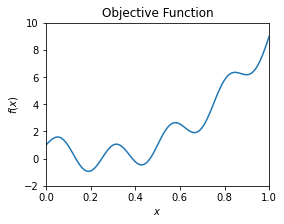

In [3]:
x = torch.linspace(0, 1, 101)
y = f(x)


fig = plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.xlim(0, 1)
plt.ylim(-2, 10)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title(f'Objective Function')
# plt.savefig('ASAobjfunc.pdf', dpi=300, facecolor='w', bbox_inches='tight')

We now attempt to locate the optimum -- in this case, the minimum -- solution.

One method is to do a grid search, i.e., computing the function at even steps over some interval in $x$.  This method will converge on the global optimum, but how long will it take?  If computing the objective function is expensive--in time, cost, or computational power--performing a grid search may not be feasible, especially if the search space is multidimensional.  For example, imagine we the curve shown is actually just one slice of a 5-dimensional curve.  If each dimension represents a parameter space over which we want to sample, and we wish to sample 100 times from every possible combination of parameters, the number of computations required will be $(10^2)^5 = 1\times10^{10}$.  If the evaluation of this function takes one second, then it will take 317 years to complete if done sequentially (not in parallel).  We can thus see how quickly grid searches scale beyond what is acceptable in terms of time to compute and cost.

A second method is to use a sampling scheme such as Markov Chain Monte Carlo sampling.

The third method which we are exploring is to create a surrogate model for our objective function which is far easier to sample from, and about which we make some assumptions in order to simplify the evaluation.

### Define Surrogate Model

Let us assume the prior for the objective function is a Gaussian process.

In [4]:
X = torch.tensor([0.1, 0.8])
y = f(X)

gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1), noise=0 * torch.tensor(0.1), jitter=5.0e-4)

In [5]:
def update_posterior(x_new):
    y = f(x_new)
    X = torch.cat([gpmodel.X, x_new])
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

### Define Acquisition Function

In [6]:
# Lower Confidence Bound:
def lower_confidence_bound(gpmodel, xi, kappa=20):
    mu, variance = gpmodel(xi, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma


# Expected Improvement:
def expected_improvement(gpmodel, xi, y_max):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    a = (mu - y_max - xi)
    z = a / sigma
    return a * norm.cdf(z) + sigma * norm.pdf(z)


# Probability of Improvement:
def probability_of_improvement(gpmodel, xi, y_max):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    z = (mu - y_max - xi) / sigma
    return norm.cdf(z)
    

def acquisition_function(func, xi, **kwargs)):
    if func == "lcb":
        pass
    return


In [10]:
def find_a_candidate(x_init, lower_bound=0, upper_bound=1, **kwargs):
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')
    
    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        alpha = acquisition_function(x)
        autograd.backward(unconstrained_x, autograd.grad(alpha, unconstrained_x))
        return y
    
    minimizer.step(closure)
    x_cand = transform_to(constraint)(unconstrained_x)
    return x_cand.detach()

### Inner Loop of Bayesian Optimization

In [11]:
def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    acq_values = []
    
    x_init = gpmodel.X[-1:]
    for _ in range(num_candidates):
        x_cand = find_a_candidate(x_init, lower_bound, upper_bound)
        alpha = lower_confidence_bound(x_cand)
        candidates.append(x_cand)
        acq_values.append(alpha)
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)
    
    argmin = torch.min(torch.cat(acq_values), dim=0)[1].item()
    return candidates[argmin]

### Running the Algorithm

In [12]:
def plot(gs, xmin, xlabel=None, with_title=True, ylim1=None, ylim2=None):
    if xlabel is None:
        xlabel = "xmin"
    else:
        xlabel = f"x{xlabel}"
    
    Xnew = torch.linspace(0., 1., 101)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.detach().cpu().numpy(), gpmodel.y.detach().cpu().numpy(), "kx")
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.detach().cpu().numpy(), loc.detach().cpu().numpy(), "r", lw=2)
        ax1.fill_between(Xnew.detach().cpu().numpy(), (loc - 2*sd).detach().cpu().numpy(), (loc + 2*sd).detach().cpu().numpy(), color="C0", alpha=0.3)
    ax1.set_xlim(0., 1.)
    if ylim1 is not None:
        ax1.set_ylim(ylim1[0], ylim1[1])
    ax1.set_title(f"Find {xlabel}")
    if with_title:
        ax1.set_ylabel("GP Regression")
    
    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        ax2.plot(Xnew.detach().cpu().numpy(), lower_confidence_bound(Xnew).detach().cpu().numpy())
        ax2.plot(xmin.detach().cpu().numpy(), lower_confidence_bound(xmin).detach().cpu().numpy(), "^", markersize=10, label=f"{xlabel} = {xmin.item():.5f}")
    ax2.set_xlim(0., 1.)
    if ylim2 is not None:
        ax2.set_ylim(ylim2[0], ylim2[1])
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.set_xlabel('x')
    ax2.legend(loc=1)

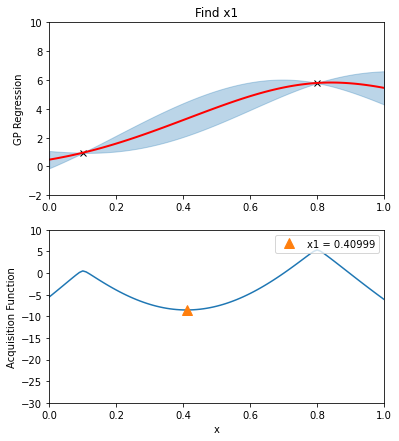

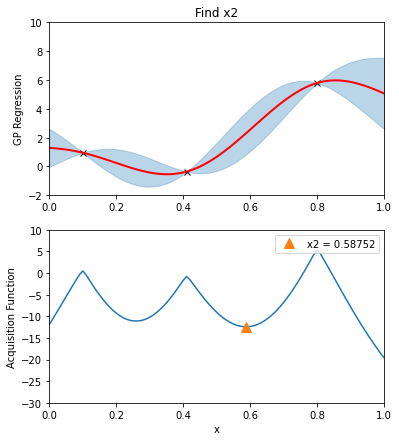

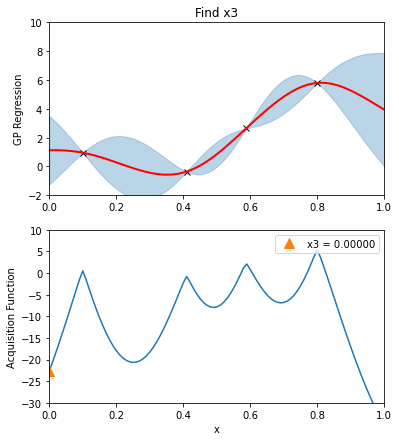

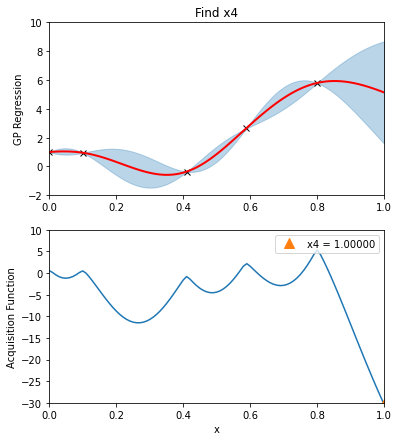

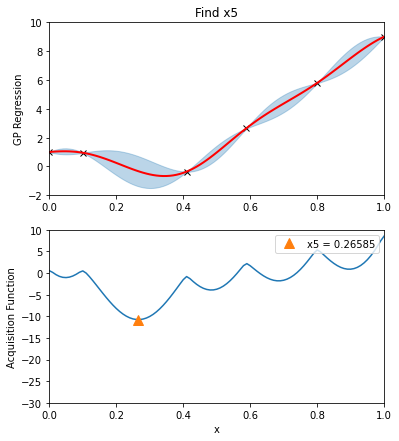

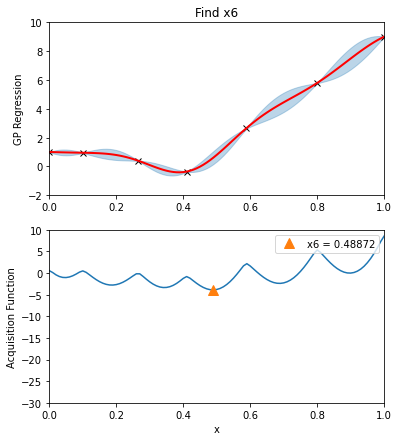

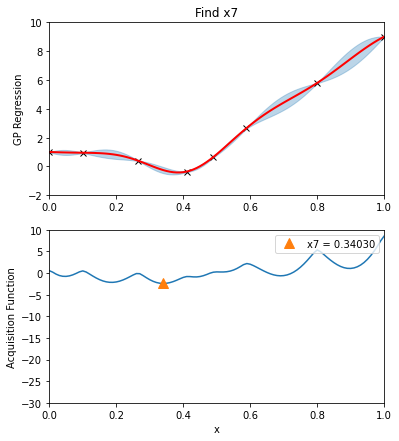

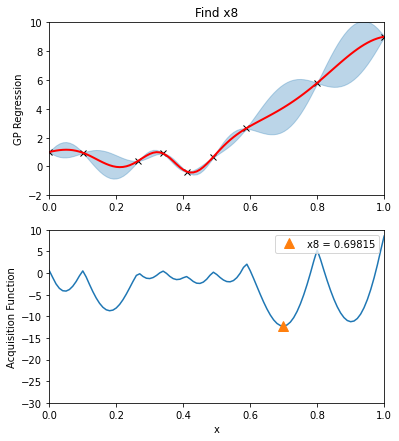

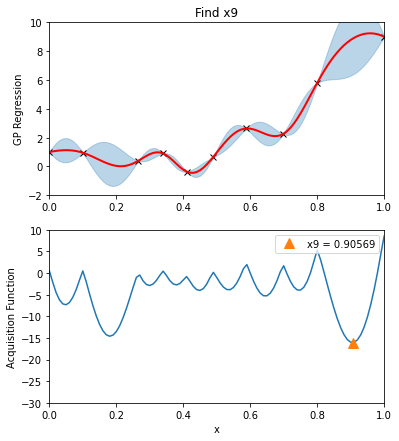

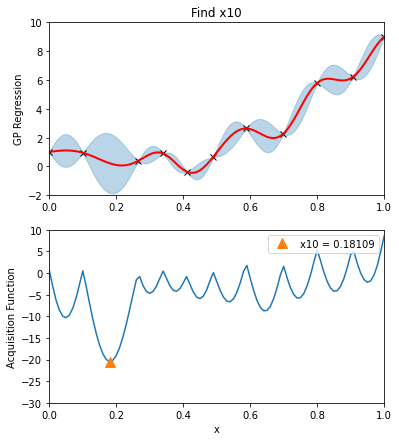

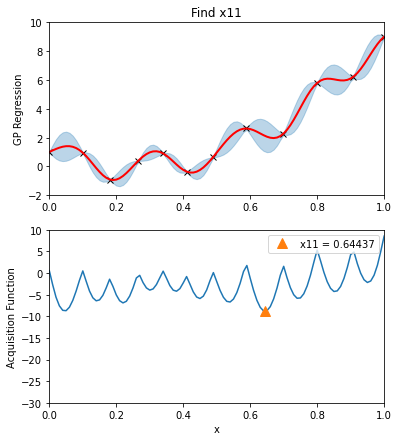

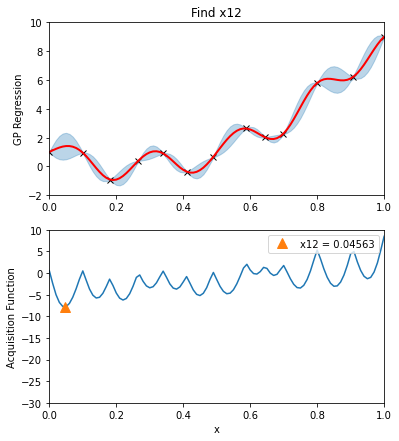

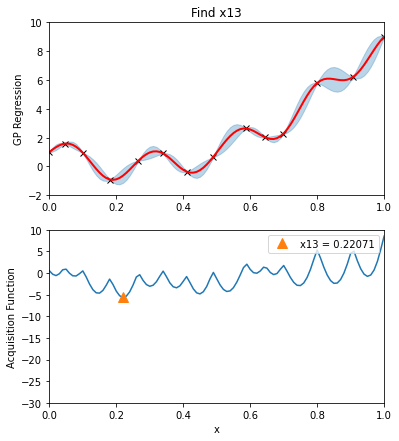

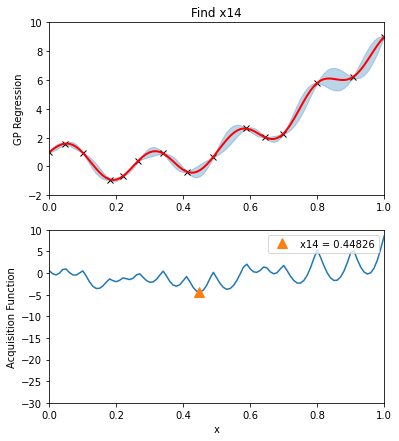

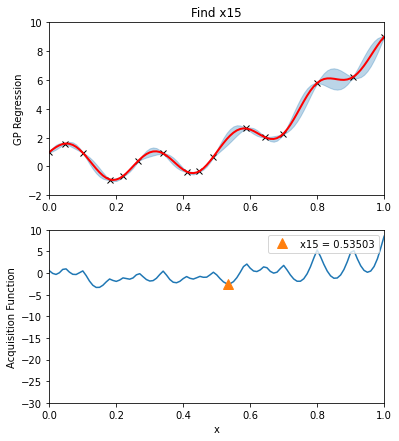

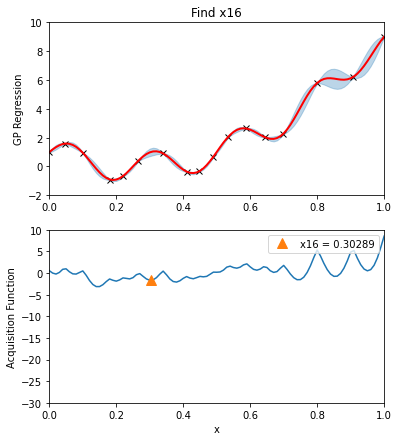

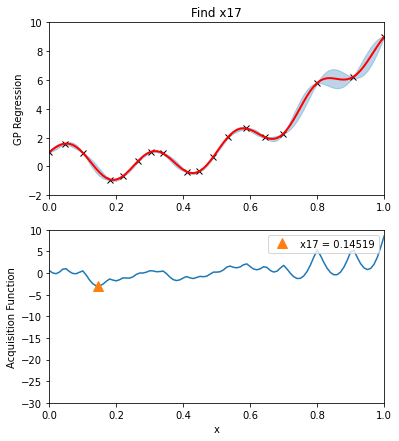

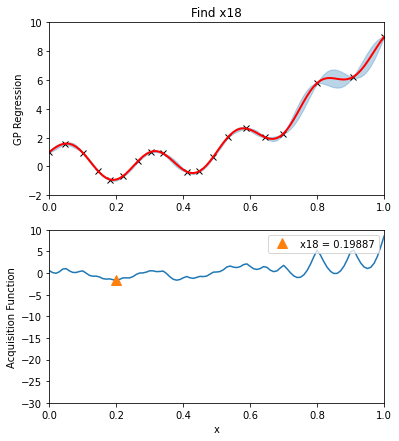

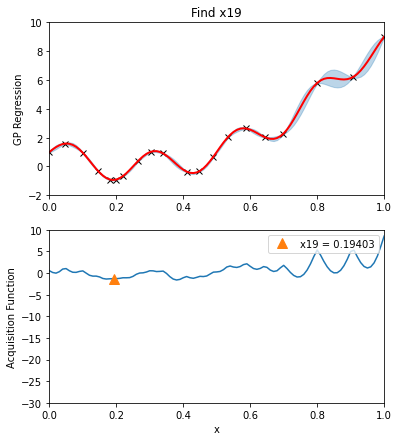

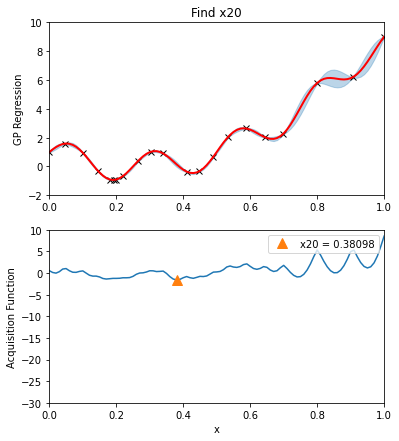

In [10]:
# plt.figure(figsize=(12, 30))
# outer_gs = gridspec.GridSpec(5, 2)
# optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
# gp.util.train(gpmodel, optimizer)
# for i in range(8):
#     xmin = next_x()
#     gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
#     plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
#     update_posterior(xmin)
# plt.show()

optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)
for i in range(20):
    xmin = next_x()
    
    fig = plt.figure(figsize=(6,7))
    gs = gridspec.GridSpec(2,1)
    plot(gs, xmin, xlabel=i+1, with_title=True, ylim1=(-2, 10), ylim2=(-30, 10))
    
    update_posterior(xmin)
    
    plt.show()
    
#     fig.savefig(f'gpanimate_{i:02d}.png', dpi=300, facecolor='w', bbox_inches="tight")
#     plt.close()

In [11]:
gpmodel.__dict__

{'_pyro_name': '',
 '_pyro_context': <pyro.nn.module._Context at 0x109b97070>,
 '_pyro_params': OrderedDict([('noise',
               (GreaterThan(lower_bound=0.0), None))]),
 '_pyro_samples': OrderedDict(),
 'training': True,
 '_parameters': OrderedDict([('noise_unconstrained',
               Parameter containing:
               tensor(-inf, requires_grad=True))]),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('kernel', Matern52())]),
 '_priors': OrderedDict(),
 '_guides': OrderedDict(),
 '_mode': 'model',
 'X': tensor([1.0000e-01, 8.0000e-01, 4.0999e-01, 5.8752e-01, 3.8410e-08, 1.0000e+00,
         2.6585e-01, 4.8872e-01, 3.4030e-01, 6.9815e-01, 9.0569e-01, 1.8109e-01,
         6.4437e-01, 4.5627e-02, 2.2071e-01, 4.48

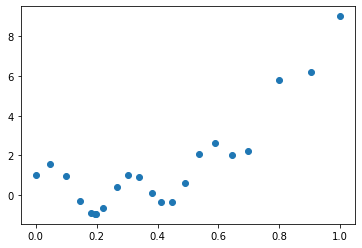

In [14]:
plt.scatter(gpmodel.X, gpmodel.y)